In [1]:
import sys, os
sys.path.append(os.path.abspath('../..'))

# State Vector and Field Variables

The modular structure of the state vector and the field variables allows for an easy construction of own custom initial conditions and fast analysis of the results. All operations that are performed on a state vector will be performed on all indiviual components of it.

In [2]:
# load modules
from fridom.NonHydrostatic.ModelSettings import ModelSettings
from fridom.NonHydrostatic.Grid import Grid
from fridom.NonHydrostatic.InitialConditions import BarotropicJet, SingleWave
from fridom.NonHydrostatic.State import State
from fridom.NonHydrostatic.Eigenvectors import VecP, VecQ
from fridom.NonHydrostatic.Plot import Plot

## Constructing a State Vector

In [3]:
# create model settings and grid
mset = ModelSettings()
grid = Grid(mset)

# construction from default constructor
z_zero = State(mset, grid)

# construction from Initial Conditions
z_jet = BarotropicJet(mset, grid)
z_wave = SingleWave(mset, grid)

# making a copy
z_jet_copy = z_jet.copy()

print("Type of State Vector: ", type(z_zero))

Type of State Vector:  <class 'FIDOM.NonHydrostatic.State.State'>


## Accessing the Field Variables

In [4]:
# access fields
u_jet = z_jet.u
v_jet = z_jet.v
w_jet = z_jet.w
b_jet = z_jet.b

print("Type of Field Variable: ", type(u_jet))

Type of Field Variable:  <class 'FIDOM.Framework.FieldVariable.FieldVariable'>


## Supported operators
Operators work component wise. For example, the sum of two states is the sum of each component (u,v,w,b) at each grid point.

In [5]:
# between states
z_sum  = z_jet + z_wave
z_diff = z_jet - z_wave
z_prod = z_jet * z_wave
z_quot = z_jet / z_wave

# between state and number
z_sum  = z_jet + 1.0
z_diff = z_jet - 1.0
z_prod = z_jet * 1.0
z_quot = z_jet / 1.0

# times equal etc.
z_jet *= 1.0                        # also works for two fields
z_jet /= 1.0                        # also works for two fields
z_jet += 1.0                        # also works for two fields
z_jet -= 1.0                        # also works for two fields

# fourier transform
z_spectral = z_jet.fft()            # fourier transform to spectral
z_physical = z_spectral.fft()       # fourier transform back to physical

# All the above operators can also be applied on the fields:
u_jet *= 1.0 
u_jet_spectral = u_jet.fft()
# ...

# Additionally, array slicing is supported for fields
u_jet[5:10] = 1.0

# Note that this is not supported for states
# the following would raise an error
# z_jet[5:10] = 1.0

## Other useful methods:

In [6]:
# get energy fields
kinetic_energy   = z_jet.ekin()             # is a field variable
potential_energy = z_jet.epot()             # is a field variable
total_energy     = z_jet.etot()             # is a field variable

# get mean energy
print("Mean kinetic Energy  : ", z_jet.mean_ekin())
print("Mean potential Energy: ", z_jet.mean_epot())
print("Mean total Energy    : ", z_jet.mean_etot())

# Get CFL number
print("Horizontal CFL number: ", z_jet.max_cfl_h())
print("Vertical CFL number  : ", z_jet.max_cfl_v())

# Get l2 norm
print("L2 norm: ", z_jet.norm_l2())

# get dot product between two states (2nd state is complex conjugated)
z1_dot_z2 = z_jet.dot(z_wave)              # is a field variable

# get norm of difference between two states
print("Norm of difference: ", z_jet.norm_of_diff(z_wave))

Mean kinetic Energy  :  0.9864538343437743
Mean potential Energy:  0.0
Mean total Energy    :  0.9864538343437743
Horizontal CFL number:  0.3204467423068982
Vertical CFL number  :  0.0
L2 norm:  1.9729076686875486
Norm of difference:  2.0


## New Custom Initial Condition

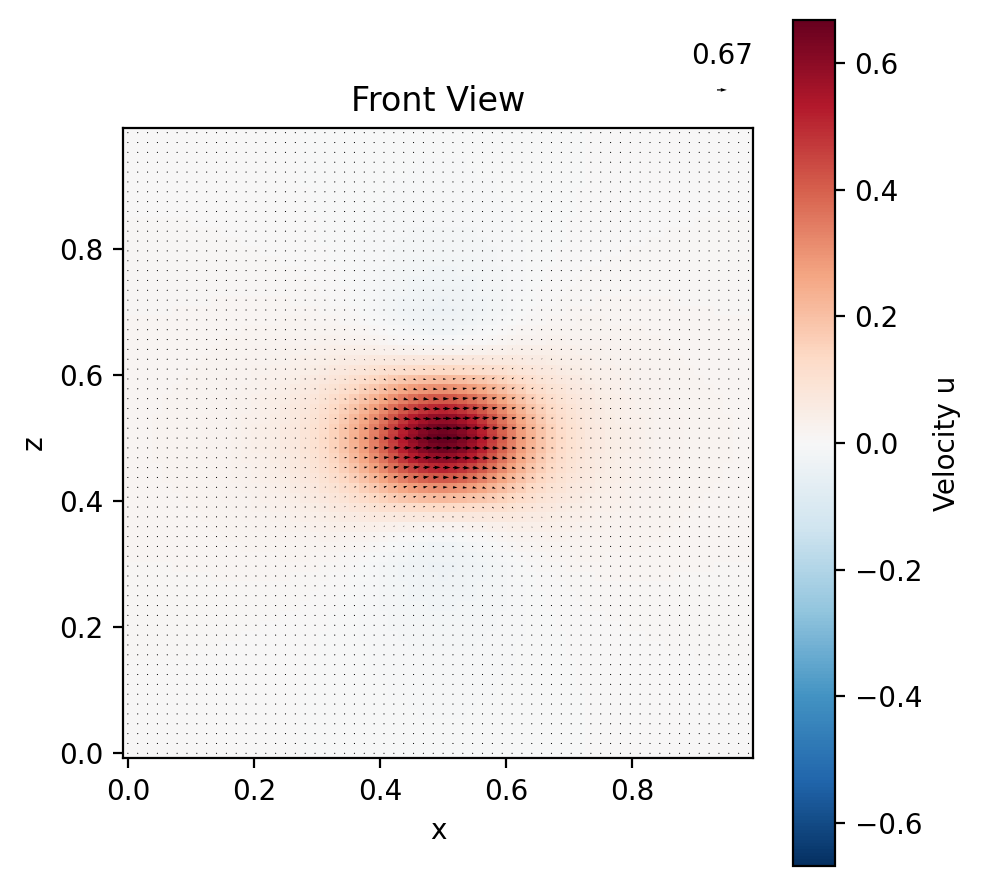

In [7]:
class Gaussian(State):
    """
    Initial condition with a gaussian velocity.
    """
    def __init__(self, mset: ModelSettings, grid: Grid, 
                 x_loc=0.5, y_loc=0.5, z_loc=0.5, radius=0.1) -> None:
        """
        Constructor.

        Args:
            mset (ModelSettings): model settings
            grid (Grid)         : grid
            x_loc (float)       : x location of gaussian. 
            y_loc (float)       : y location of gaussian. 
            z_loc (float)       : z location of gaussian.
        """
        super().__init__(mset, grid)

        # get numpy or cupy module
        cp = self.cp                     # is cupy if gpu is enabled

        # get meshgrid
        X, Y, Z = tuple(self.grid.X)

        # set gaussian velocity
        self.u[:] = cp.exp(-((X - x_loc) / radius)**2) * \
                    cp.exp(-((Y - y_loc) / radius)**2) * \
                    cp.exp(-((Z - z_loc) / radius)**2)

        # remove divergence from velocity field
        # see projection section for more details
        z_div = self.project(VecP("d", mset, grid), VecQ("d", mset, grid))
        self.u -= z_div.u; self.v -= z_div.v; self.w -= z_div.w

        return

# create the gaussian state and plot it
z_gauss = Gaussian(mset, grid)
Plot(z_gauss.u).front(z_gauss, y=0.5)
